In [133]:
# Load dependencies
import xarray as xr
import climlab
import sys
sys.path.append('/home/fspauldinga/SAM24a/RFM/rfmtools')
import rfmtools
from scipy import ndimage
from matplotlib import cm
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.figure as mplf
import os
import time
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker,colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, ScalarFormatter, NullFormatter)
import matplotlib.pylab as pyl
from labellines import labelLines,labelLine
import pickle
from scipy.special import lambertw
from collections.abc import Sequence
from typing import Type,Dict
from scipy.interpolate import interp1d
if True:
    # Get plot settings
    pltfac = 2
    dim = 3.2*pltfac
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 10*pltfac}
    mpl.rc('font', **font)
    lticksmajor = 3*pltfac
    lticksminor = lticksmajor/2
    wticks = lticksmajor/4
    msize = 1.5*(4*pltfac)**2
    
# Step 0: Define the case and the resolution
class parameters:
    def __init__(self,**params):
        # Spectral resolution used in RFM experiments
        self.nu0 = params.get('nu0', 1)  # cm-1
        self.nu1 = params.get('nu1', 3000)  # cm-1
        self.dnu = params.get('dnu', 0.1)  # cm-1
        self.band = params.get('band', 'titan')
        self.runtype = params.get('runtype', 'cooling')
        self.cpdef = params.get('cp', 29012 / 28.964)  # J/kg/K (default RFM value of specific heat)
        self.nsday = params.get('nsday', 86400)  # seconds per Earth-day
        self.TEMREL = params.get('TEMREL', 0)  # ground-air temp diff.

        # spectral range calculations
        self.nus = np.arange(self.nu0, self.nu1 + self.dnu, self.dnu)
        if self.band == 'titan':
            self.i0 = np.squeeze(np.where(np.abs(self.nus - self.nu0) == np.min(np.abs(self.nus - self.nu0))))
            self.i1 = np.squeeze(np.where(np.abs(self.nus - self.nu1) == np.min(np.abs(self.nus - self.nu1))))
        self.nnus = len(self.nus)

        # Thermodynamic parameters
        self.ps = params.get('ps', 1.5e5)
        self.Ts = params.get('Ts', 93)
        self.Ttrp = params.get('Ttrp', 71)
        self.Gamma = params.get('Gamma', 0.55e-3)
        self.z = params.get('z', np.arange(0, 5e4, 1))

        # Additional thermodynamic parameters
        self.Ttrip = params.get('Ttrip', 90.68)  # K 
        self.ptrip = params.get('ptrip', 11700.) # Pa
        self.E0v   = params.get('E0v', 4.9e5)      # J/kg 
        self.ggr   = params.get('ggr', 1.35)       # m/s^2, gravity
        self.rgasa = params.get('rgasa', 296.8)  # J/kg/K, specific gas constant of dry air
        self.rgasv = params.get('rgasv', 518.28) # J/kg/K, specific gas constant of methane vapor
        self.cva   = params.get('cva', 707.2)      # J/kg/K, isovolumetric specific heat of dry air
        self.cvv   = params.get('cvv', 1707.4)     # J/kg/K, isovolumetric specific heat of methane vapor
        self.cvl   = params.get('cvl', 3381.55)    # J/kg/K, isovolumetric specific heat of liquid methane
        self.cpa   = params.get('cpa', self.cva + self.rgasa)  # isobaric specific heat of dry air
        self.cpv   = params.get('cpv', self.cvv + self.rgasv)  # isobaric specific heat of methane vapor
        self.eps   = params.get('eps', self.rgasa / self.rgasv) # ratio of specific gas constants
        self.L     = params.get('L', 5.5e5)          # enthalpy of vaporization of methane
        self.E0s   = params.get('E0s', np.nan)     # no ice phase
        self.cvs   = params.get('cvs', np.nan)     # no ice phase
        
        # Titan-like composition parameters
        self.xH2   = params.get('xH2',0.001)  # molar mixing ratio of hydrogen (0.1%)
        self.MN2   = params.get('MN2',2*14.01*1e-3)  # molecular weight of N2 (kg/mol)
        self.MCH4  = params.get('MCH4',(12.01+4*1.008)*1e-3) # molecular weight of CH4 (kg/mol)
        self.MH2   = params.get('MH2',2*1.008*1e-3)  # molecular weight of H2 (kg/mol)
        self.Runi  = params.get('Runi',8.314) # universal gas constant (J/mol/K)
        self.RN2   = params.get('RN2',self.Runi/self.MN2) # specific gas constant of N2 (J/kg/K)
        self.RCH4  = params.get('RCH4',self.Runi/self.MCH4) # specific gas constant of CH4 (J/kg/K)
        self.RH2   = params.get('RH2',self.Runi/self.MH2) # specific gas constant of H2 (J/kg/K)
        
        # Initialize case string
        self.case = ""
        
    def generate_case(self,**params):
        planet       = params.get('planet','unknown')
        self.RHs     = params.get('RHs',0.75)
        self.RHmid   = params.get('RHmid',0.54)
        self.RHtrp   = params.get('RHtrp',0.75)
        self.Tmid    = params.get('Tmid',82)
        self.uniform = params.get('uniform',1)
        # Extract gases in a dynamic way (gas1, gas2, ... gasN)
        gases = [params[key] for key in sorted(params) if key.startswith('gas')]
        # Create the case string based on the fixed order
        self.case = '-'.join([planet] + gases + [str(int(self.RHmid*100)), str(self.Tmid), str(self.uniform)])
        
par = parameters()
par.generate_case(planet='titan',gas1='N2',gas2='CH4',gas3='H2',RHs=0.75,RHmid=0.54,RHtrp=0.75,uniform=1)
print(par.case)
gases = ['N2','CH4','H2']

def get_custom_atm(par,vres1=np.arange(0,5e4,1e2),vres2=np.arange(0,5e4,1e2)):
    # scalar inputs: mid-tropospheric RH (RHmid) and temeprature (Tmid) and boolean option for uniform RH
    # Vertical resolution can also be specified to facilitate RFM vs analytical model. 
    #############################################################
    def get_optimal_RH(Tsfc2trp, Ts=300, Tmid=260, Ttrp=200, RHs=0.75, RHmid=0.4, RHtrp=0.75):
        print('Ts',Ts)
        print('Tmid',Tmid)
        print('Ttrp',Ttrp)
        print('RHs',RHs)
        print('RHmid',RHmid)
        print('RHtrp',RHtrp)
        # Compute alpha_left and alpha_right based on target RH values
        alpha_left  = -np.log(RHtrp / RHmid)/(Ttrp - Tmid) ** 2
        alpha_right = -np.log(RHs / RHmid)/(Ts - Tmid) ** 2 
        # Compute RH values for the provided temperature range
        RH_opt = [
            RHmid * np.exp(-(temp - Tmid) ** 2 * alpha_left) if temp < Tmid else RHmid * np.exp(-(temp - Tmid) ** 2 * alpha_right)
            for temp in Tsfc2trp
        ]
        return {'RH':RH_opt,'alpha_lt':alpha_left, 'alpha_gt':alpha_right}
    #############################################################
    def get_esat_over_l(par,T):
        import math
        # SVP over liquid from DAM (Pa)
        pstar = par.ptrip * (T/par.Ttrip)**((par.cpv-par.cvl)/par.rgasv) * math.exp( (par.E0v - (par.cvv-par.cvl)*par.Ttrip) / par.rgasv * (1/par.Ttrip - 1/T) )
        return pstar
    #############################################################
    # Lapse Rate and Temperature (Troposphere)
    Gamma = np.ones([len(par.z)],dtype='float')*par.Gamma
    T  = par.Ts - par.Gamma*par.z
    # stratospheric mask
    mask = np.where(T<par.Ttrp)
    # Lapse Rate and Temperature (Stratosphere)
    T  = np.where(T<par.Ttrp,par.Ttrp,T)
    Gamma[mask] = 0
    # Identify the height of the tropopause
    ktrp = int(np.amin(np.where(T==par.Ttrp)))
    ztrp = par.z[ktrp]
    # Custom RH
    if par.uniform is True:
        RH       = np.ones([len(par.z)])*par.RHmid
        RH[mask] = 0
        alpha_lt = 0
        alpha_gt = 0
    else:
        RH  = np.ones([len(par.z)])*par.RHs
        RH[mask] = 0 # stratospheric mask
        foo = get_optimal_RH(T[0:(ktrp+1)], par.Ts, par.Tmid, par.Ttrp, par.RHs, par.RHmid, par.RHtrp)
        RH[0:(ktrp+1)] = foo['RH']
        alpha_lt       = foo['alpha_lt']
        alpha_gt       = foo['alpha_gt']
    
    # Solve for environmental pressure and density 
    rho  = np.zeros_like(par.z)
    p    = np.ones_like(par.z)*par.ps
    arg  = 0
    # initialize molar mixing ratios (relative to total)
    xN2  = np.zeros_like(par.z)
    xCH4 = np.zeros_like(par.z)
    xH2  = np.ones_like(par.z)*par.xH2
    # initialize mass mixing ratios (relative to total)
    wN2  = np.zeros_like(par.z)
    wCH4 = np.zeros_like(par.z)
    wH2  = np.zeros_like(par.z)
    # initialize specific gas constant
    Rtot  = np.zeros_like(par.z)
    # initialize mean molecular mass
    Mave  = np.zeros_like(par.z)
    for k in range(len(par.z)):
        if k<(len(par.z)-1):
            dz   = par.z[k+1]-par.z[k]
        else:
            dz   = par.z[1]-par.z[0]
        # molar mixing ratio of CH4 
        if k<=ktrp: # tropospheric value set by Clausius-Clapeyron
            pCH4    = RH[k]*get_esat_over_l(par,T[k])
            xCH4[k] = pCH4/p[k]
        else: # stratospheric mixing ratio fixed to tropopause value
            xCH4[k] = xCH4[ktrp]
        # molar mixing ratio of N2
        xN2[k]  = 1-xCH4[k]-xH2[k]
        # mean molecular weight of air
        Mave[k] = (1-xCH4[k])*par.MN2 + xCH4[k]*par.MCH4 + xH2[k]*(par.MH2-par.MN2)
        # mass mixing ratios of H2, CH4, and N2
        wH2[k] = xH2[k]*par.MH2/Mave[k]
        wN2[k] = xN2[k]*par.MN2/Mave[k]
        wCH4[k]= xCH4[k]*par.MCH4/Mave[k]
        tol = 1e-6  # Adjust this value based on your precision requirements
        if abs(wH2[k] + wN2[k] + wCH4[k] - 1) > tol:
            print(f'Error: sum of mixing ratios is non-unity ({wH2[k] + wN2[k] + wCH4[k]}). Tolerance exceeded.')
        # specific gas constant of air
        Rtot[k] = wN2[k]*par.RN2 + wCH4[k]*par.RCH4 + wH2[k]*par.RH2
        # solve for total density of air
        rho[k] = p[k]/(Rtot[k]*T[k])
        # solve for exponential term
        arg    = -par.ggr/Rtot[k]*dz/T[k]
        # solve for pressure at next level
        if k<(len(par.z)-1):
            p[k+1] = p[k]*np.exp(arg)
    #############################################################
    # Export fields in their desired vertical resolution (vres1,vres2)
    def interpolate(var, vres):
        # func = interp1d(par.z,var,kind)(input of function)
        return interp1d(par.z, var, kind='cubic')(vres)
    T1, T2         = interpolate(T, vres1), interpolate(T, vres2)
    Gamma1, Gamma2 = interpolate(Gamma, vres1), interpolate(Gamma, vres2)
    p1, p2         = interpolate(p, vres1), interpolate(p, vres2)
    rho1, rho2     = interpolate(rho, vres1), interpolate(rho, vres2)
    RH1, RH2       = interpolate(RH, vres1), interpolate(RH, vres2)
    xN2_1, xN2_2   = interpolate(xN2, vres1), interpolate(xN2, vres2)
    xCH4_1, xCH4_2 = interpolate(xCH4, vres1), interpolate(xCH4, vres2)
    xH2_1, xH2_2   = interpolate(xH2, vres1), interpolate(xH2, vres2)
    #############################################################
    dat1 = {'T': T1, 'p': p1, 'Gamma': Gamma1, 'rho': rho1, 'z': vres1, 'RH': RH1,
            'xN2': xN2_1, 'xCH4': xCH4_1, 'xH2': xH2_1}
    dat2 = {'T': T2, 'p': p2, 'Gamma': Gamma2, 'rho': rho2, 'z': vres2, 'RH': RH2,
            'xN2': xN2_2, 'xCH4': xCH4_2, 'xH2': xH2_2}
    #############################################################
    # T(K), RH(unitless), p(Pa), Gamma(K/m), rho(kg/m3), x(molar mixing ratio)
    #############################################################
    return dat1,dat2

titan-N2-CH4-H2-54-82-1


In [134]:
dat1,dat2 = get_custom_atm(par)

Ts 93
Tmid 82
Ttrp 71
RHs 0.75
RHmid 0.54
RHtrp 0.75


[82.]
[54216.63440551]


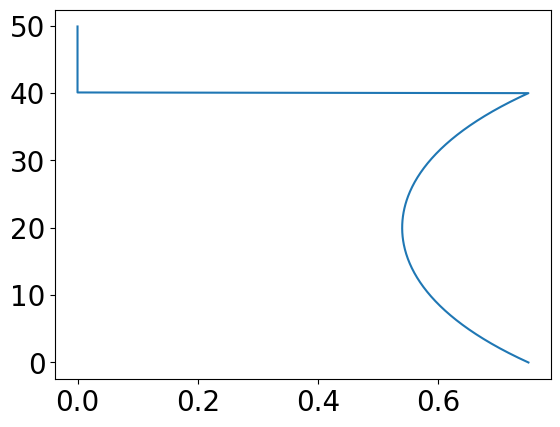

In [143]:
fig, ax = plt.subplots()
ax.plot(dat1['RH'],dat1['z']/1e3)

arg = np.absolute(dat1['T']-82)
k = np.where(arg == np.min(arg))
print(dat1['T'][k])
print(dat1['p'][k])

In [ ]:
def run_RFM(dataset):
    # The inputs must be provided at the desired RFM resolution.
    #############################################################
    par = dataset['par']
    #############################################################
    TEMREL = par.TEMREL # sea-air dT (>0 means warmer surface))
    heights = dataset['RFM']['z']               # Height (m)
    nus = par.nus                               # Wavenumbers (cm-1)
    temps = dataset['RFM']['T']                 # Temperature (K)
    p = dataset['RFM']['p'] / 1e2               # Pressure (hPa)
    #############################################################
    # Tropopause information
    ktrp = np.amin(np.where(temps == par.Ttrp))  # Tropopause index
    ztrp = heights[ktrp]                         # Tropopause height
    #############################################################
    # Automatically handle all gas species
    print("run_RFM: Including the following gases in the input file:")
    xgases = {}
    for key, value in dataset['RFM'].items():
        if key.startswith('x'):  # Identify gas mixing ratios (e.g., xN2, xCH4)
            xgases[key] = value * 1.0e6  # Convert from mol/mol->ppmv
            print(f"  - {key[1:].upper()} [ppmv]")
    #############################################################
    # Generate the RFM input file dynamically
    rfmtools.make_input_files.generate_atm_file(
        f'{par.case}.atm',
        heights / 1e3,  # Convert to km
        temps,
        p,
        **xgases  # Pass all detected gases' molar mixing ratios [ppmv]
    )
    #############################################################
    # Create LEV file (space-separated vertical coordinates in km)
    np.savetxt(rfmtools.utils.RFM_DIR+'/lev/%s.lev'%(par.case), heights/1e3, delimiter=' ')
    #############################################################
    # Generate RFM driver
    # https://pds-atmospheres.nmsu.edu/education_and_outreach/encyclopedia/gas_constant.htm
    PHY = (' CPKMOL=29012.0' + '\n' +        # molar heat capacity of air (J/K/kmol) (used for COO only)
                 ' GRAVTY=1.35'    + '\n' +  # m/s^2 (ignored by HYD flag)
                 ' RADCRV=2575.'   + '\n' +  # local radius of curvature (km)
                 ' TEMSPA=2.7'     + '\n' +  # cosmic background temperature (K)
                 ' WGTAIR=100000.')          # molar mass of air (kg/kmol) (ignored by HYD flag)
    print(PHY)
    if runtype=='cooling':
        rfmtools.make_input_files.make_driver(
            runtype=par.runtype,   # WV continuum: "cooling"(off) or "continuum_cooling"(on)
            fname='rfm.drv',
            atmfile='%s.atm'%(par.case), 
            SPC=f"{par.nu0} {par.nu1} {par.dnu}", # spectral range (cm-1)
            GAS=" ".join([xgas[1:] for xgas in xgases]), # e.g., "H2O CO2 CH4"
            HIT=rfmtools.utils.RFM_DIR+"/hit/titan_n2_ch4_h2_1_3000_hitran20.par", # hitran coefficients
            OUTDIR=rfmtools.utils.RFM_DIR+'/outp/%s'%(par.case),
            PHY=PHY,
            NLEV=rfmtools.utils.RFM_DIR+'/lev/%s.lev'%(par.case),
            SFC="TEMREL=%.1f"%(TEMREL))
    elif runtype=='continuum_cooling':
        rfmtools.make_input_files.make_driver(
            runtype=par.runtype,   # WV continuum: "cooling"(off) or "continuum_cooling"(on)
            fname='rfm.drv',
            atmfile='%s.atm'%(par.case), 
            SPC=f"{par.nu0} {par.nu1} {par.dnu}", # spectral range (cm-1)
            GAS=" ".join([xgas[1:] for xgas in xgases]), # e.g., "H2O CO2 CH4"
            HIT=rfmtools.utils.RFM_DIR+"/hit/titan_n2_ch4_h2_1_3000_hitran20.par", # hitran coefficients
            OUTDIR=rfmtools.utils.RFM_DIR+'/outp/%s'%(par.case),
            PHY=PHY,
            NLEV=rfmtools.utils.RFM_DIR+'/lev/%s.lev'%(par.case),
            SFC="TEMREL=%.1f"%(TEMREL))
    elif runtype=='od_trans':
        rfmtools.make_input_files.make_driver(
            runtype=par.runtype,  
            fname='rfm.drv',
            atmfile='%s.atm'%(par.case), 
            SPC=f"{par.nu0} {par.nu1} {par.dnu}", # spectral range (cm-1)
            GAS=" ".join([xgas[1:] for xgas in xgases]), # e.g., "H2O CO2 CH4"
            HIT=rfmtools.utils.RFM_DIR+"/hit/titan_n2_ch4_h2_1_3000_hitran20.par", # hitran coefficients
            OUTDIR=rfmtools.utils.RFM_DIR+'/outp/%s'%(par.case),
            PHY=PHY,
            NLEV=rfmtools.utils.RFM_DIR+'/lev/%s.lev'%(par.case))
    elif runtype=='continuum_od_trans':
        rfmtools.make_input_files.make_driver(
            runtype=par.runtype,  
            fname='rfm.drv',
            atmfile='%s.atm'%(par.case), 
            SPC=f"{par.nu0} {par.nu1} {par.dnu}", # spectral range (cm-1)
            GAS=" ".join([xgas[1:] for xgas in xgases]), # e.g., "H2O CO2 CH4"
            HIT=rfmtools.utils.RFM_DIR+"/hit/titan_n2_ch4_h2_1_3000_hitran20.par", # hitran coefficients
            OUTDIR=rfmtools.utils.RFM_DIR+'/outp/%s'%(par.case),
            PHY=PHY,
            NLEV=rfmtools.utils.RFM_DIR+'/lev/%s.lev'%(par.case))     
    elif runtype=='kabs':
        rfmtools.make_input_files.make_kabs_driver(
            runtype=par.runtype,  
            fname='rfm.drv',
            atmfile='%s.atm'%(par.case),
            SPC=f"{par.nu0} {par.nu1} {par.dnu}", # spectral range (cm-1)
            GAS=" ".join([xgas[1:] for xgas in xgases]),
            HIT=rfmtools.utils.RFM_DIR+"/hit/titan_n2_ch4_h2_1_3000_hitran20.par", # hitran coefficients
            OUTDIR=rfmtools.utils.RFM_DIR+'/outp/%s'%(par.case),
            PHY=PHY,
            TAN="1 550 1 82 1 100")
            #TAN="PLV 180 320 10") # use p,T values from atmfile for the look-up table
            #TAN="/home/fspauldinga/RFM/dat/pfile.dat\n/home/fspauldinga/RFM/dat/Tfile.dat") # T,p values for the look-up table
    elif runtype=='continuum_kabs':
        rfmtools.make_input_files.make_kabs_driver(
            runtype=par.runtype,  
            fname='rfm.drv',
            atmfile='%s.atm'%(par.case),
            SPC="10 1500 0.1", # spectral range (cm-1)
            GAS=" ".join([xgas[1:] for xgas in xgases]), # e.g., "H2O CO2 CH4"
            HIT=rfmtools.utils.RFM_DIR+"/hit/titan_n2_ch4_h2_1_3000_hitran20.par", # hitran coefficients
            OUTDIR=rfmtools.utils.RFM_DIR+'/outp/%s'%(par.case),
            PHY=PHY,
            TAN="1 550 1 82 1 100")
    #############################################################
    # Run RFM
    print(rfmtools.utils.RFM_DIR)
    rfmrun = rfmtools.run.run(drv_file=rfmtools.utils.RFM_DIR+"/src/rfm.drv")
    #############################################################
    print(f'done with RFM for '+" ".join([xgas[1:] for xgas in xgases]))
    return

To integrate in pressure, we need access to $R_a = w_{N2} R_{N2} + w_{CH4} R_{CH4} + w_{H2} R_{H2}$, where $w$ is the mass mixing ratio (relative to total mass) of each component. By writing the ideal gas law as $p=nkT$, it is simple to solve for the mole fraction (relative to total) of each component as: $1 = x_{N2} + x_{CH4} + x_{H2}$. Note that we will set $x_{H2} = 0.001$ as a constant. So, we need only solve for $0.999 = x_{N2} + x_{CH4}$. Recall that the mass mixing ratio can be written as $w_i = x_i \frac{M_i}{\bar M}$.

Given these essential facts, it follows that: <br>
(1) $\bar M = (1-x_{CH4}) M_{N2} + x_{CH4} M_{CH4} + x_{H2}(M_{H2}-M_{N2})$ <br>
(2) $x_{CH4} = \frac{p_{CH4}}{p_{tot}} = \frac{RH\times e^*}{p_{tot}}$ <br>
(3) Given $\bar M$, $w_{CH4} = x_{CH4} M_{CH4}/\bar M$, $w_{N2} = (1-x_{H2}-x_{CH4})M_{N2})/\bar M$, and $w_{H2} = x_{H2} M_{H2}/\bar M$ <br>
(4) Given $w$, $R_a = w_{N2} R_{N2} + w_{CH4}R_{CH4} + w_{H2} R_{H2}$ follows. <br>
(5) Given $R_a$, the hydrostatic pressure change can be calculated for $p$.

In [138]:
def generate_atm_file(fname, height, temp, pres, **gases):
    """
    Generate a .atm input file for RFM.
    
    Inputs:
    * gases: molar mixing ratios in ppmv, for example,
    variables = [height, pres, temp, h2o, np.ones(nz)*co2] 
    """
    nz = int(len(height))
    
    # Standard variables
    variables = [height, pres, temp]
    labels=["*HGT [km]","*PRE [mb]","*TEM [K]"]
 
    #labels=["*HGT [km]","*PRE [mb]","*TEM [K]","*H2O [ppmv]","*CO2 [ppmv]","*CH4 [ppmv]"]
    
    # Add gases dynamically
    for gas_name, gas_profile in gases.items():
        # Ensure consistent naming: 'xCO2' → '*CO2 [ppmv]'
        gas_label = f"*{gas_name[1:].upper()} [ppmv]" if gas_name.startswith('x') else f"*{gas_name.upper()} [ppmv]"
        
        # Error checking for correct array length
        if len(gas_profile) != nz:
            raise ValueError(f"Length mismatch for {gas_name}: expected {nz}, got {len(gas_profile)}")
        
        print(f'appending {gas_label} to atm file')
        labels.append(gas_label)
        variables.append(gas_profile)
    
    with open(RFM_DIR+"/atm/"+fname,"w+") as file:
        file.write("! Produced using rfmtools - Andrew Williams 2021. \n")
        file.write("! andrew.williams@physics.ox.ac.uk \n ")
        
        file.write(f" {nz} ! No.Levels in profiles \n")
        
        for idx, label in enumerate(labels):
            file.write(f"{label} \n")
            x=",       ".join([str(i) for i in variables[idx]])
            file.write(f" {x} \n")
        file.write("*END")
    file.close()
    
import numpy as np

nz = 10
height = np.linspace(0, 10, nz)
temp = np.linspace(288, 220, nz)
pres = np.linspace(1013, 100, nz)
h2o = np.linspace(10000, 1, nz)
co2 = np.full(nz, 400)     # CO2 at 400 ppmv
ch4 = np.full(nz, 1.8)     # CH4 at 1.8 ppmv
n2 = np.full(nz, 780840)   # N2 at 78.084%

generate_atm_file("example.atm", height, temp, pres, xH2O=h2o, xCO2=co2, xCH4=ch4, xN2=n2)

appending *H2O [ppmv] to atm file
appending *CO2 [ppmv] to atm file
appending *CH4 [ppmv] to atm file
appending *N2 [ppmv] to atm file


NameError: name 'RFM_DIR' is not defined